## Rozwiążanie równania Schrodingera za pomocą FDTD (Finite-Difference Time-Domain)

**Teoria**

Jedno wymiarowe zależne od czasu równanie Schödingera ma postać:

$$ i\hbar \frac{\partial \Psi(x,t)}{\partial t} = - \frac{\hbar^2}{2m} \frac{\partial^2 \Psi(x,t)}{\partial x^2} +U(x,t) \Psi(x, t)$$ 

gdzie: $\Psi(x, t)$ - funkcja falowa, $U(x, t)$ - potencjał, w jakim porusza się cząstka, $m$ - masa cząstki, $\hbar$ - stała Plancka.

Funkcja falowa jest funkcją zespoloną, więc możemy ją wyrazić w postaci:

$$\Psi(x,t) = \Psi_{r}(x,t) + i \Psi_{I}(x, t)$$

To nam pozwala na przedstawienie równania Schödingera tylko w dziedzinie rzeczywistej za pomocą dwóch równań:

$$ \hbar \frac{\partial \Psi_{r}(x, t)}{\partial t} =  - \frac{\hbar^2}{2m} \frac{\partial^2 \Psi_{I}(x,t)}{\partial x^2} +U(x,t) \Psi_{I}(x, t)$$ 

$$ \hbar \frac{\partial \Psi_{I}(x, t)}{\partial t} =   \frac{\hbar^2}{2m} \frac{\partial^2 \Psi_{r}(x,t)}{\partial x^2} - U(x,t) \Psi_{r}(x, t)$$ 

Stosując metode różnic skończonych musimy zdefiniować siątkę, czyli zbiór
dyskretnych punktów w przestrzeni i czasie, w których będziemy szukać rozwiązania.
Każdy punkt przestrzeni leży w odległości $\Delta x$, a czas rózni się o $\Delta t$.


Funkcję przybliżamy za pomocą metody różnic skończonych: 

$$ \frac{\partial \Psi(x,t)}{\partial t} \approx \frac{\Psi(x,t+\Delta t) - \Psi(x,t)}{\Delta t}$$

$$ \frac{\partial^2 \Psi(x,t)}{\partial x^2} \approx \frac{\Psi(x \Delta x,t) - 2 \Psi(x,t) + \Psi(x - \Delta x,t)}{\Delta x^2}$$

Stosująć podejście numeryczne otrzymujemy następujące postacie na wyliczenie 
części rzeczywistej $\Psi_R$ i urojonej $\Psi_I$ funkcji falowej:
    
$$ \Psi_R[i] = \Psi_R[i] - C_1 \cdot (\Psi_I[i+1] -2 \Psi_I[i] + \Psi_I[i-1]) + C_2 \cdot (U[i] \cdot \Psi_R[i])$$  

$$ \Psi_I[i] = \Psi_I[i] - C_1 \cdot (\Psi_R[i+1] -2 \Psi_R[i] + \Psi_R[i-1]) + C_2 \cdot (U[i] \cdot \Psi_I[i])$$ 
    
gdzie współczyniki $C_1$ i $C_2$ wynoszą: $C_1 = \frac{\Delta t \hbar}{2 m \Delta x^2}$ oraz $C_2= \frac{e \Delta t}{\hbar}$

Aby móc symulować elektron, musimy zainicjować cząstkę o długości fali $\lambda$ w postaci obwiedni o szerokości $\sigma$ wyrażonej za pomocą funkcji Gaussa. Dla części rzeczywistej:
    $$y_R = \exp \left(-0.5 \left(\frac{x-x_c}{\sigma} \right)^2 \right) \cos \left( \frac{2 \pi (x-x_c)}{\lambda} \right) $$
  Dla części urojonej:
 $$ y_I = \exp \left(-0.5 \left(\frac{x-x_c}{\sigma} \right)^2 \right) \sin \left( \frac{2 \pi (x-x_c)}{\lambda}  \right) $$

Prawdopodobieństwo znalezienia cząstki musi być znormalizowane aby spełnić warunek:

$$ \int_{-\infty}^{\infty} \Psi^* (x) \Psi (x) dx  =  \int_{-\infty}^{\infty} y_{R}^2 + y_{I}^2 dx = 1$$

## Program 

Na początku importujemy potrzebne biblioteki 

In [75]:
%matplotlib qt5
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

plt.rcParams.update({'font.size':25})

Ustawiamy parametry $N$ - liczba punktów siatki, $T$ - liczba kroków czasu, $dx$ - różnica między punktami przestrzennymi, $m$ - masa cząstki $\hbar$ - stała Plancka, $\sigma$ - szerokość obwiedni, $E$ - energia cząstki, $X$ - siatka.

Energię cząstki można zmienić np. przez zmianę wartośc parametru $k0$ będącym liczbą falową.

In [76]:
N = 10800
T = 4*N
dx = 1
m = 1
h_bar = 1
sigma = 40.0
time_shift = round(N/2) - 5*sigma
k0 = np.pi/10
E = (h_bar**2/2.0/m)*(k0**2+0.5/sigma**2)
X = dx*np.linspace(0, N, N)
print("Energia = {}".format(E))

Energia = 0.049504272005446784


Następnie definiujemy potrzebne funkcje: funkcję wyrażającą potencjał, w jakim będzie poruszać się cząstka oraz funkcje Gaussa.

In [77]:
def gauss_function(x, x_c, sigma):
    return np.exp(-(x-x_c)**2/(2*sigma**2))


def barrier(n , v0, thickness):
    v = np.zeros(n)
    v[int(n/2):int(n/2)+thickness] = v0
    return v

Ustawiamy barierę potencjału o wysokości 0.050 oraz grubość 5, w jakim będzie się poruszać cząstka. Wyznaczamy współczynniki $C_1$ i $C_2$.

In [78]:
v_barrier = 0.050
thickness = 5
V = barrier(N, v_barrier, thickness)
tau = h_bar/(2*h_bar**2/(m*dx**2)+max(V)) 
C1 = (tau*h_bar)/(2*m*dx*dx)
C2 = 2*tau/h_bar
C2V = C2*V

Następnie inicjalizujemy tablice reprezentującą funkcję falową, która przechowuje trzy stany:
przeszyły, obecny i przyszły. inicjalizujemy stan początkowy.

In [79]:
psi_real = np.zeros((3, N))
psi_imaginary = np.zeros((3, N))
psi_probability = np.zeros((3, N))

x_n = range(1, int(N/2))
x = X[x_n]/dx

gauss = gauss_function(x, time_shift, sigma)
cos_x = np.cos(k0*x)
sin_x = np.sin(k0*x)

psi_real[0, x_n] = cos_x*gauss
psi_imaginary[0, x_n] = sin_x * gauss
psi_real[1, x_n] = cos_x*gauss
psi_imaginary[1, x_n] = sin_x*gauss

Dokonujemy normalizacji funkcji falowej na podstawie obliczonego stanu funkcji falowej.

In [80]:
psi_probability = psi_real[1]**2 + psi_imaginary[1] ** 2
P = dx*psi_probability.sum()
normalize = np.sqrt(P)
psi_real = psi_real/normalize
psi_imaginary = psi_imaginary / normalize
psi_probability = psi_probability/normalize

Symulacja w czasie wykonujemy przez podstawienie obecnego stanu funkcji falowej na stan poprzedni i przyszłego na obecny linijka 27 i 28 kodu poniżej.

In [81]:
print("Start obliczeń, proszę czekać")
idex1 = range(1, N-1)
idex2 = range(2, N)
idex3 = range(0, N-2)
psi_in_time = np.zeros(( int(np.ceil(N/200.0)), N))

for i in range(0, N):
    psi_real_present = psi_real[1]
    psi_imaginary_present = psi_imaginary[1]

    psi_imaginary[2, idex1] = psi_imaginary[0, idex1] + \
                              C1 * (psi_real_present[idex2] - 2 * psi_real_present[idex1] +
                                    psi_real_present[idex3])
    psi_imaginary[2] -= C2V * psi_real[1]

    psi_real[2, idex1] = psi_real[0, idex1] - \
                         C1 * (psi_imaginary_present[idex2] - 2 * psi_imaginary_present[idex1] +
                               psi_imaginary_present[idex3])
    psi_real[2] += C2V * psi_imaginary[1]

    psi_prob = psi_real_present ** 2 + psi_imaginary_present ** 2
    P = dx * psi_prob.sum()
    normalize = np.sqrt(P)
    psi_r = psi_real_present / normalize
    psi_i = psi_imaginary_present / normalize
    psi_prob = psi_prob / normalize

    psi_real[0] = psi_real_present
    psi_real[1] = psi_real[2]
    psi_imaginary[0] = psi_imaginary_present
    psi_imaginary[1] = psi_imaginary[2]
    if i%200==0:
        psi_in_time[int(i/200), :] = psi_prob
print("Obliczenia skończone")

Start obliczeń, proszę czekać
Obliczenia skończone


Poniżej kod, który generuje wykres.

In [82]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Palatino'
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.unicode'] = True
plt.rcParams.update({'font.size': 35})
plt.rcParams['text.latex.preamble'] = r'\usepackage[T1]{polski}'


fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax2.fill(X, V, color='green', alpha=0.8)
ax2.plot([0, N], [E, E], 'k--')
ax1.plot(X, psi_in_time[0], 'r-', linewidth=3, label="$t=0$")
ax1.plot(X, psi_in_time[52], 'b-', linewidth=3, label="$t=52$")
ax1.set_xlabel("położenie, $x$")
ax1.set_ylabel("prawdopodobieństwo, $\Psi$")
ax2.set_ylabel("Energia, $E$")
plt.text(5500, 0.040, "V={} \n d={}".format(v_barrier, thickness), color="green")
ax1.legend(loc=7)
plt.show()

Kod, który generuje animacje. W razie problemów należy spróbować doinstalowanie pakiet ffmpeg przez polecenie:

```conda install -c menpo ffmpeg```

In [83]:
from matplotlib import animation, rc
from IPython.display import HTML

rc('animation', html='html5')
plt.rcParams.update({'font.size':15})

fig, ax3 = plt.subplots()
plot_psi, = ax3.plot([], [], color="red", lw=2, label="$\Psi$")
plt.legend(loc=6)
ax4 = ax3.twinx()
ax4.fill(X, V, color='green', alpha=0.8)
ax4.plot([0, N], [E, E], 'k--', label="energia cząstki")
plt.legend(loc=2)

def init():
     plot_psi.set_data([], [])
     return (plot_psi,)

def run(i):
    plot_psi.set_data(X, psi_in_time[i])
    return plot_psi,

anim = animation.FuncAnimation(fig, run, init_func=init, frames=50, interval=500, blit=True)
HTML(anim.to_html5_video())

## Symulacja dla różnych warunków


In [84]:
from IPython.display import Image

Na wykresie poniżej pokazana jest ewolucja funkcji falowej dla dwóch czasów $t=0$ oraz $t=52$ przy barierze
potencjału $V=0.05$ oraz grubości $d=5$, energia cząstki wynosi $E=0.0495$

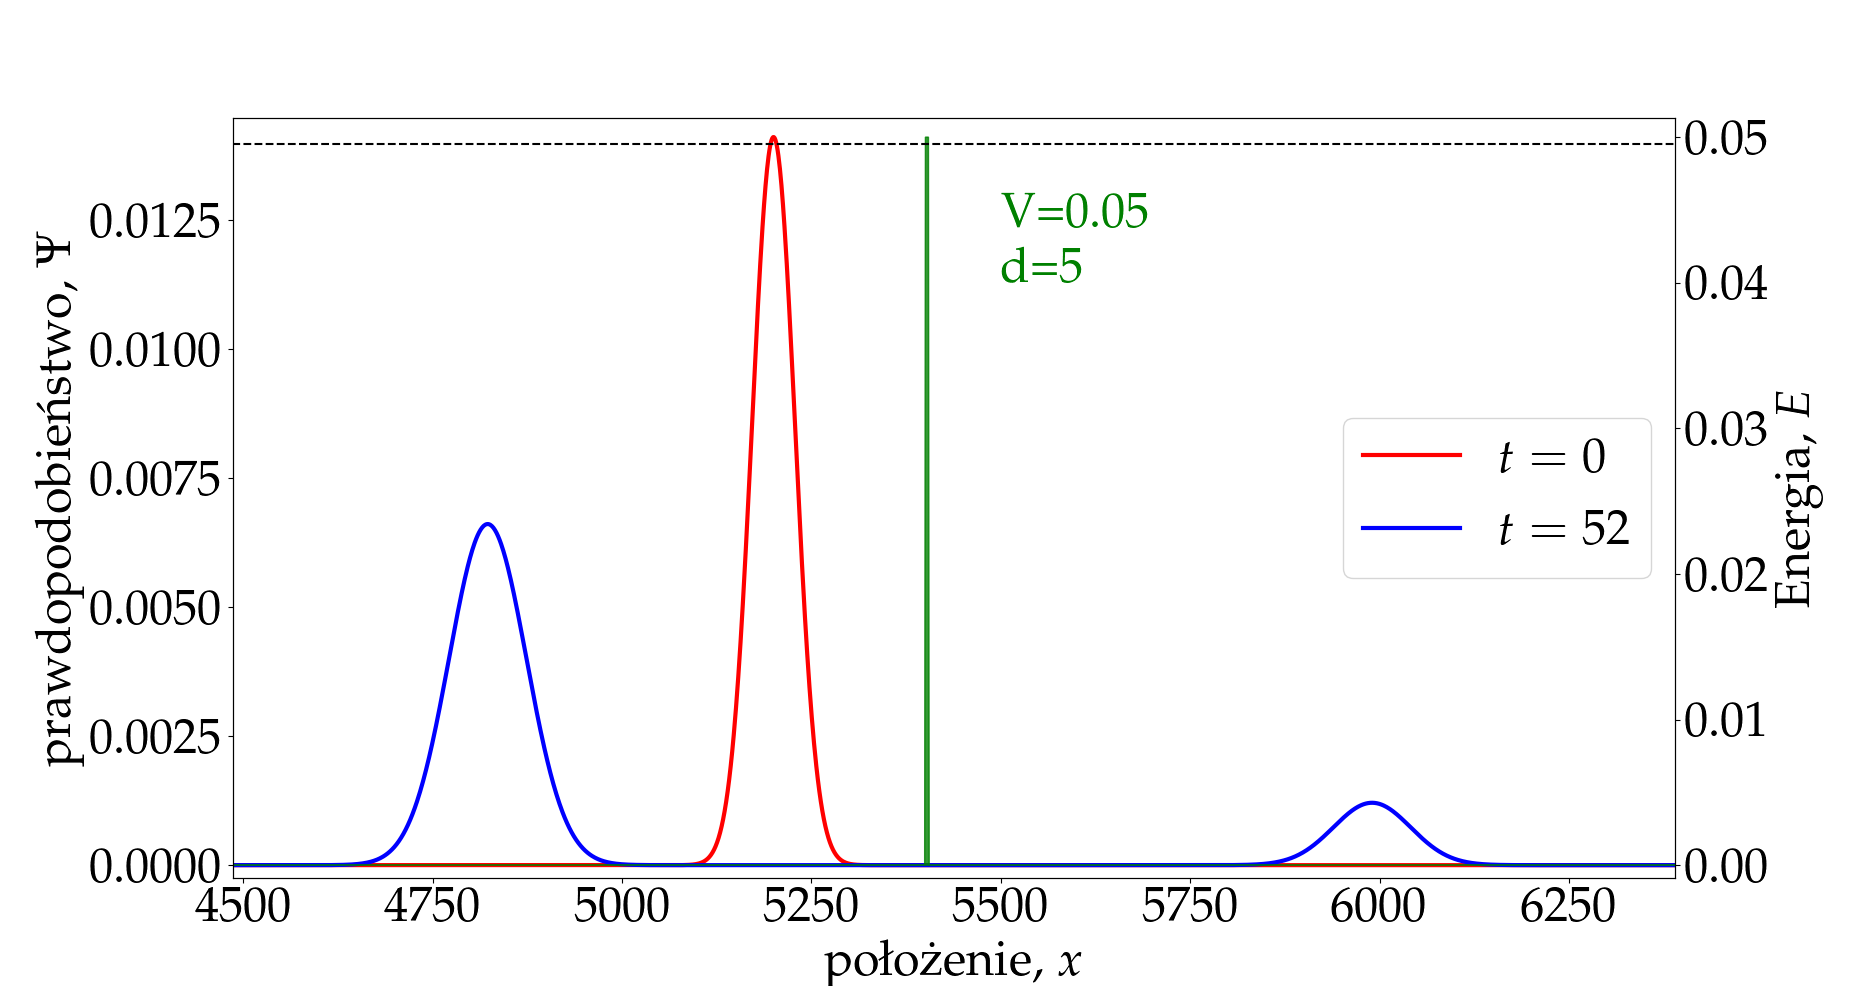

In [85]:
Image(filename='V0_05_d5.png')

Na wykresie poniżej pokazana jest ewolucja funkcji falowej dla dwóch czasów $t=0$ oraz $t=52$ przy barierze
potencjału $V=0.05$ oraz grubości $d=10$, energia cząstki wynosi $E=0.0495$

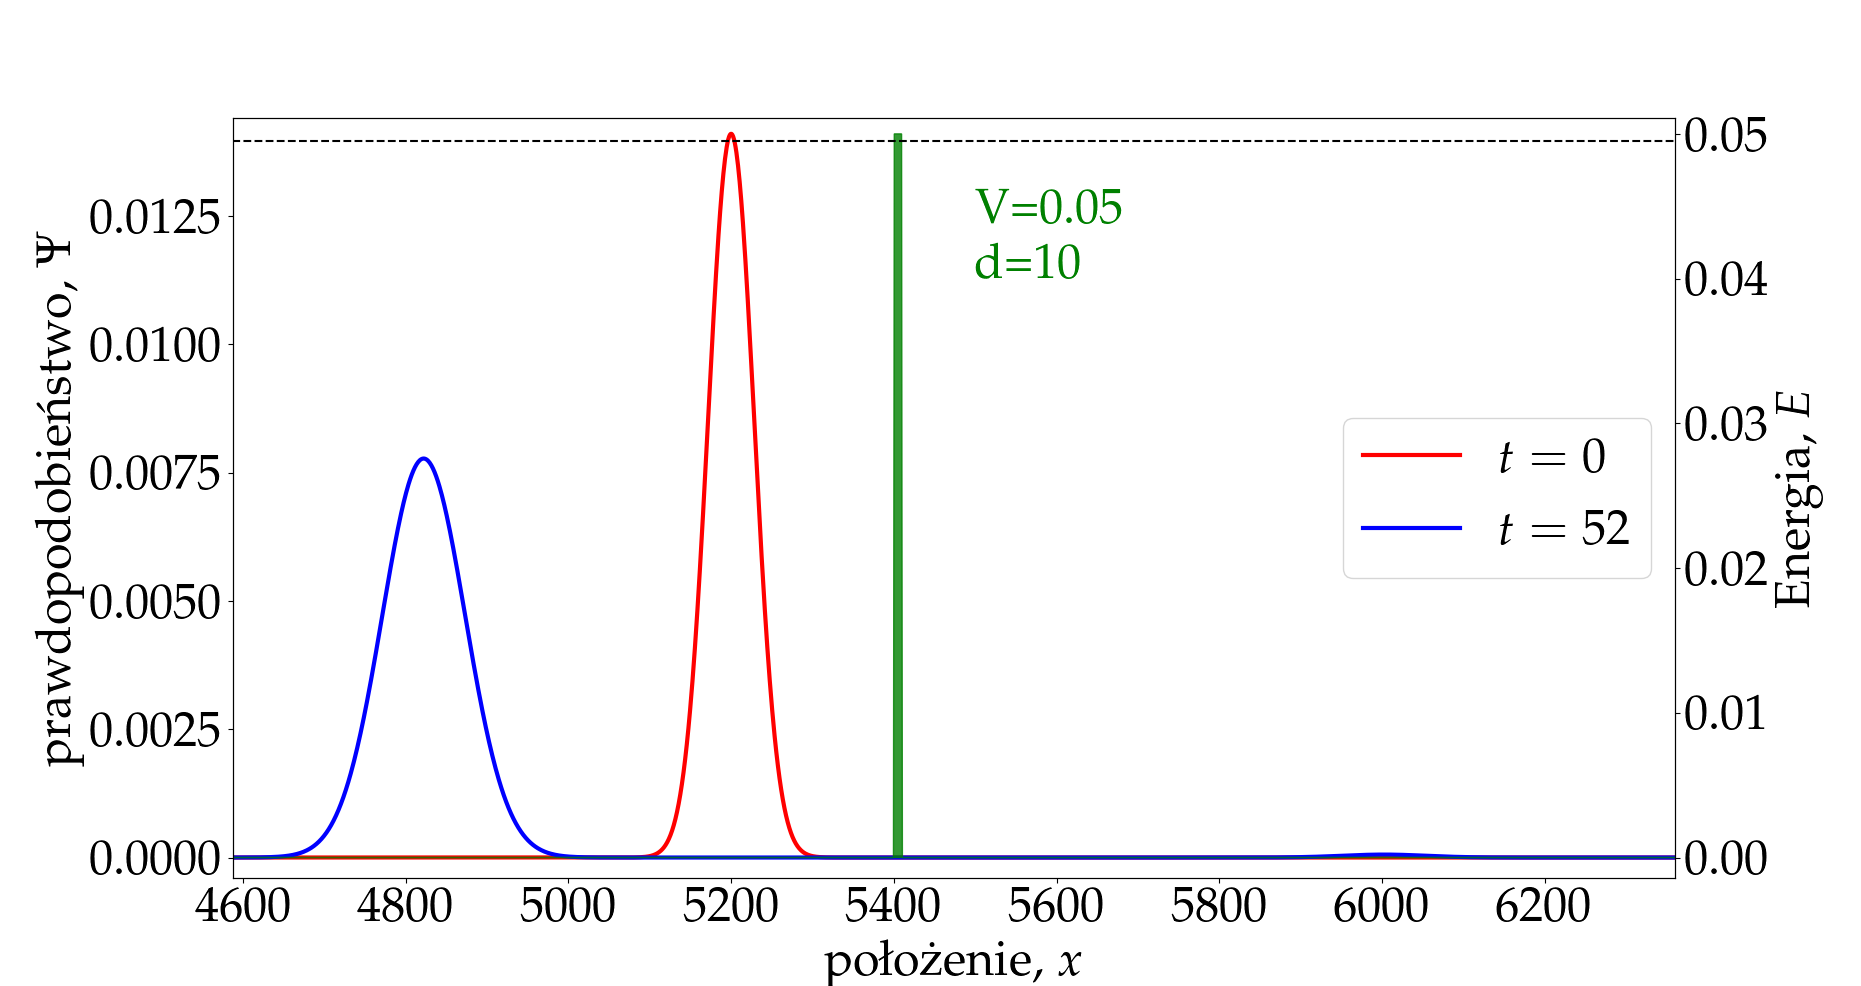

In [86]:
Image(filename='V0_05_d10.png')

Na wykresie poniżej pokazana jest ewolucja funkcji falowej dla dwóch czasów $t=0$ oraz $t=52$ przy barierze
potencjału $V=0.05$ oraz grubości $d=10$, energia cząstki wynosi $E=0.0772$

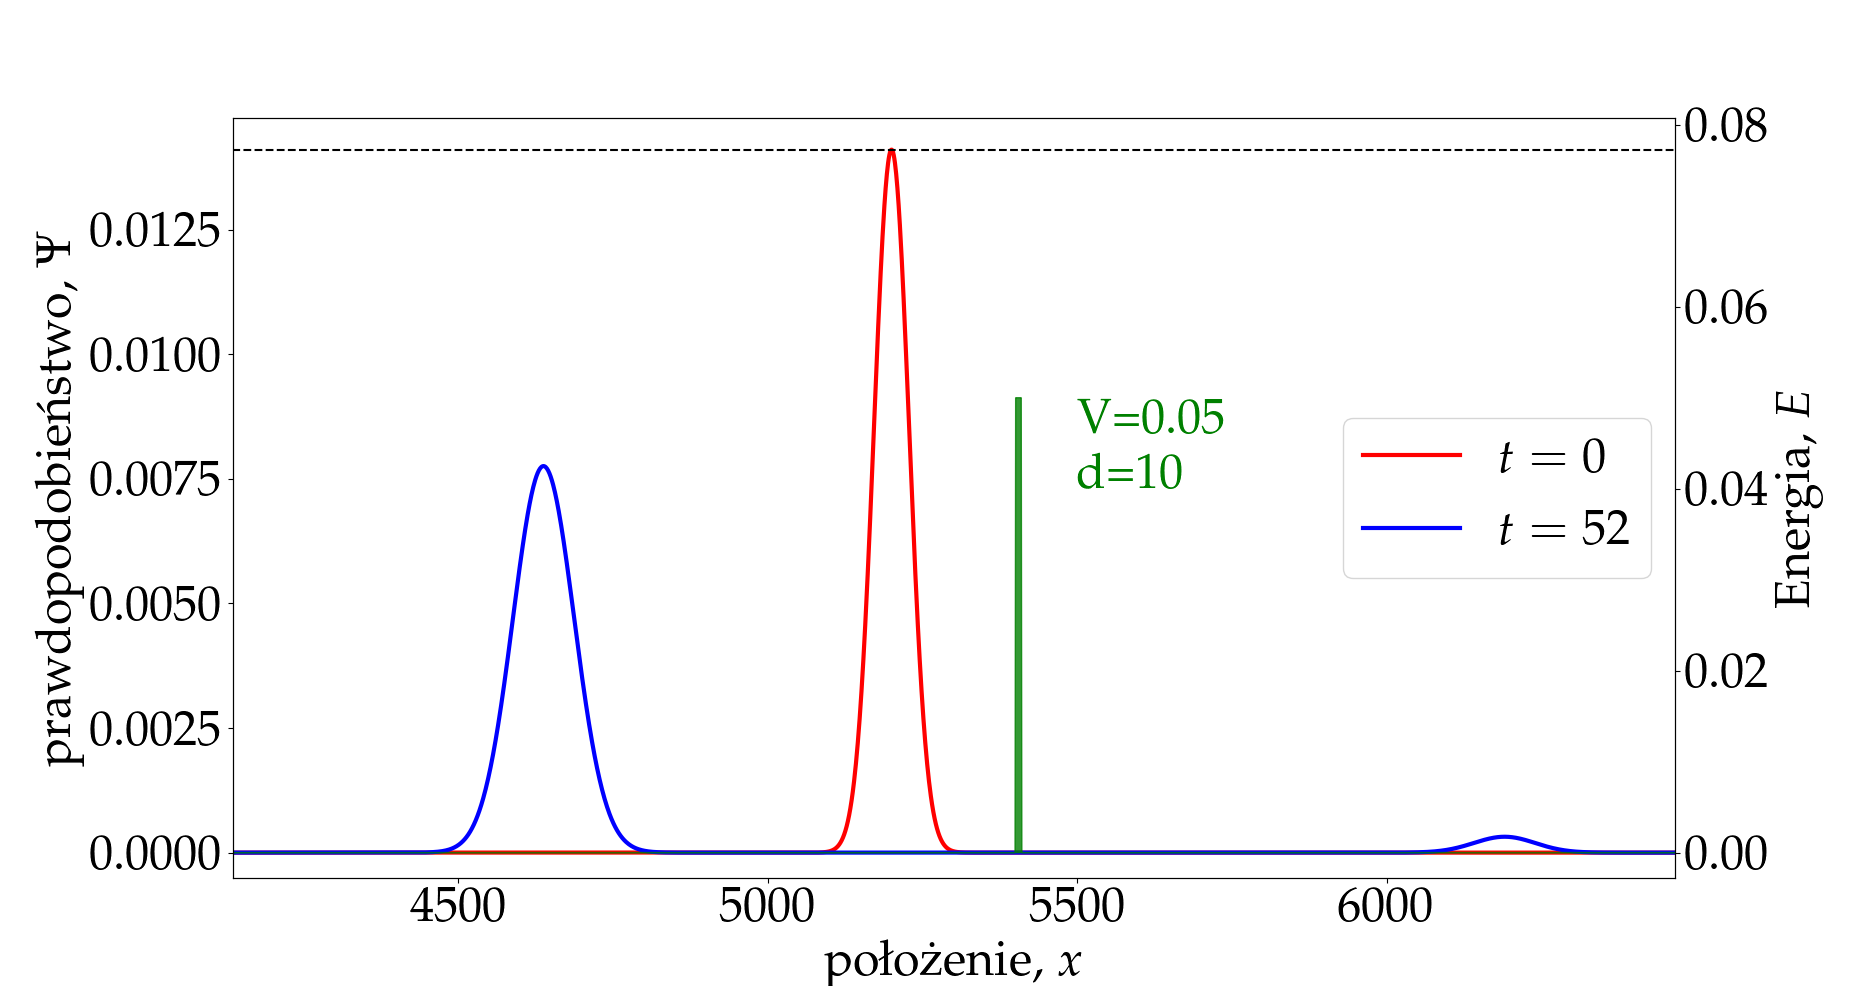

In [87]:
Image(filename='V0_05_d10_e2.png')

Na wykresie poniżej pokazana jest ewolucja funkcji falowej dla dwóch czasów $t=0$ oraz $t=52$ przy barierze
potencjału $V=0.05$ oraz grubości $d=5$, energia cząstki wynosi $E=0.0772$

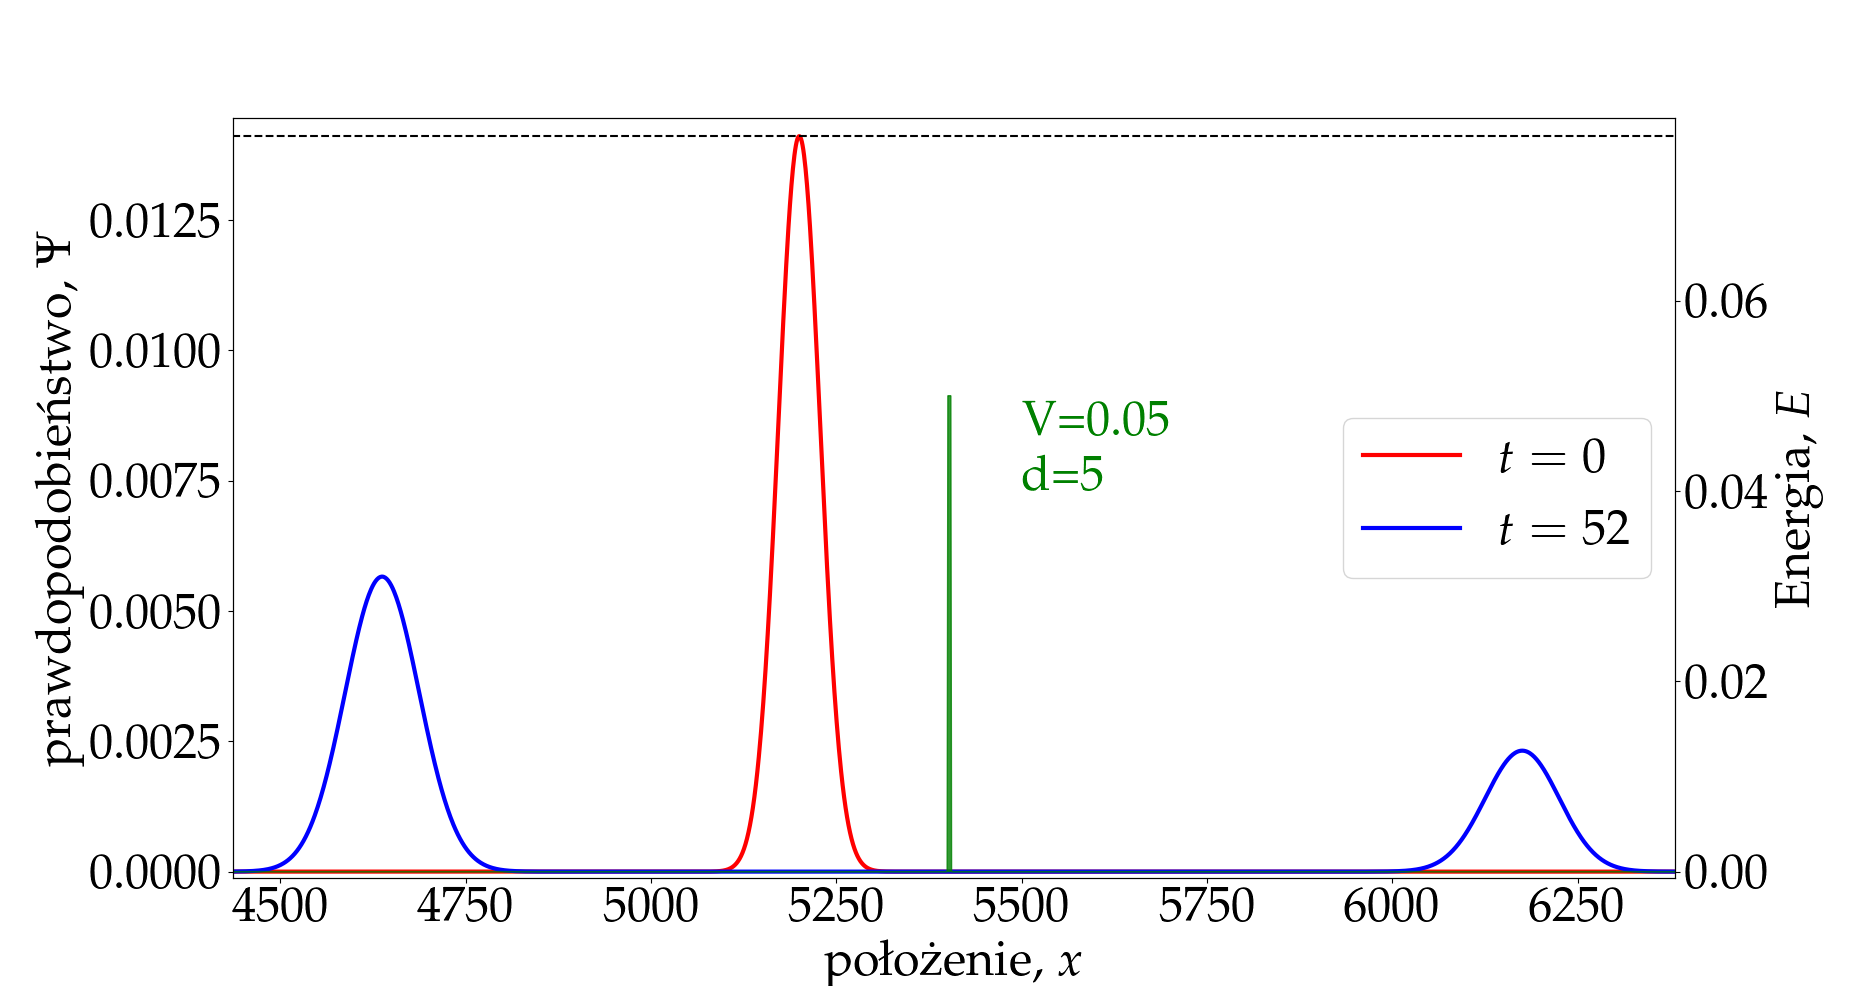

In [88]:
Image(filename='V0_05_d5_e2.png')

## Podsumowanie

Jak widzimy na przedstawionych powyżej wykresach:
* Na dwóch pierwszych wykresach przedstawiona jest sytuacja, gdy energia cząstki $E$ była mniejsza niż wartość bariery $V$, więc niezerowa wartość funkcji falowej po drugiej stronie bariery świadczy o występowaniu zjawiska tunelowania.
* Im grubość bariery była większa, tym prawdopodobieństwo $\Psi$ znalezienia cząstki po drugiej stronie bariery w sposób znaczący spadało.
* Im energia cząstki była większa, tym prawdopodobieństwo $\Psi$ znalezienie cząstki po drugiej stronie bariery rosło. Prawdopodobieństwo to w dużym stopniu zależało od grubości bariery.